In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

print(f'Tensorflow version: {tf.__version__}')
print(f'Keras version: {keras.__version__}')

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.visible_device_list = '0'
session = InteractiveSession(config=config)

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

Using TensorFlow backend.


Tensorflow version: 2.2.0
Keras version: 2.3.0-tf


In [2]:
general_path = ('D:/Datasets/Nexperia/Images/')

train_path = ('D:/Datasets/Nexperia/Images/Train/')
test_path = ('D:/Datasets/Nexperia/Images/Test/')
validation_path = ('D:/Datasets/Nexperia/Images/Validation/')

image_count = sum(len(files) for _, _, files in os.walk(train_path))
CLASS_NAMES = np.array([name for name in os.listdir(train_path) if os.path.isdir(general_path)])

In [3]:
BATCH_SIZE = 64
TARGET_SIZE = (224,224)

datagen = ImageDataGenerator(rescale=1./255)

train_images_gen = datagen.flow_from_directory(train_path, batch_size=BATCH_SIZE, target_size=TARGET_SIZE, shuffle=True, classes=list(CLASS_NAMES))
test_images_gen = datagen.flow_from_directory(test_path, batch_size=BATCH_SIZE, target_size=TARGET_SIZE, shuffle=True)

Found 30000 images belonging to 2 classes.
Found 3000 images belonging to 1 classes.


In [4]:
train_images_gen.class_indices['bad']

# train_images.classes[0]

0

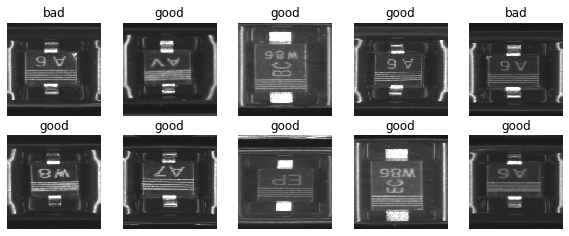

In [5]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    
    for img_num in range(10):
        ax = plt.subplot(5,5,img_num+1)
        plt.imshow(image_batch[img_num])
        plt.title(CLASS_NAMES[label_batch[img_num]])
        plt.axis('off')

tuner_image, batch_label = next(train_images_gen)

tuner_label = []
for iter_tuner in range(len(batch_label)):
    if (batch_label[iter_tuner][0] == 0.0):
        tuner_label.append(1)
    else:
        tuner_label.append(0)
tuner_label = np.array(tuner_label) 

show_batch(tuner_image, tuner_label)

In [6]:
tuner_label.shape

(64,)

In [7]:
def build_model(hp):
    model = keras.Sequential([
        keras.layers.Conv2D(
            filters = hp.Int('conv_1_filter', min_value = 32, max_value = 128, step = 16),   
            kernel_size = hp.Choice('conv_1_kernel', values = [3,5,7]),                
            activation = 'relu',
            input_shape = (224, 224, 3)
        ),
        keras.layers.Conv2D(
            filters = hp.Int('conv_2_filter', min_value = 32, max_value = 128, step = 16),
            kernel_size = hp.Choice('conv_2_kernel', values = [3,5,7]),
            activation = 'relu'
        ),
        keras.layers.Flatten(),
        keras.layers.Dense(
            units = hp.Int('dense_1_units', min_value = 32, max_value = 128, step = 16),
            activation = 'relu'
        ),
        keras.layers.Dense(2, activation = 'softmax')     
        ])

    model.compile(optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])),
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'])
    
    return model

In [ ]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

tuner_search = RandomSearch(build_model, max_trials = 5, objective = 'val_accuracy', project_name='Kerastuner', directory='D:/Datasets/Nexperia/',)

with tf.device('/CPU:0'):
    tuner_search.search(tuner_image, tuner_label, epochs = 3, validation_split = 0.1, verbose = 2)

INFO:tensorflow:Reloading Oracle from existing project D:/Datasets/Nexperia/Kerastuner\oracle.json
Epoch 1/3


In [ ]:
model = tuner_search.get_best_models(num_models=1)[0]
model.summary()

In [ ]:
model.fit(
        train_images_gen, 
        epochs=10, initial_epoch=0, 
        validation_split=0.1,
        verbose=2
        )

In [ ]:
model.fit(
        train_images_gen,
        steps_per_epoch=np.ceil(image_count/BATCH_SIZE),
        epochs=10
        )
model.save_weights('first_try.h5')